<a href="https://colab.research.google.com/github/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/Spike_train_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


Most of the interesting things that happen in living organisms result from networks of interactions, whether among neurons in the brain, genes in a single cell, or amino acids in single protein molecule.  Especially in the context of neural networks, there is a long tradition of using ideas from statistical physics to think about the emergence of collective behavior from the microscopic interactions, with the hope that this functional collective behavior will be robust (universal?) to our ignorance of many details in these systems.  In the past decade or so, new experimental techniques have made it possible to monitor the activity of many biological networks much more completely, and the availability of these data has made the problems of analysis much more urgent: given what the new techniques can measure, can we extract a global picture of the network dynamics?  In this lecture I'll show how an old idea, the maximum entropy construction, can be used to attack this problem.  What is most exciting is that this construction provides a path directly from real data to the classical models of statistical mechanics.  I'll describe in detail how this works for a network of neurons in the retina as it responds to complex, naturalistic inputs, where the relevant model is exactly the Ising model with pairwise, frustrated interactions.   Remarkably, the data suggest that the system is poised very close to a critical point. I'll try to highlight some open theoretical questions in this field, as well as making connections to other systems.  Again, I hope we'll see the outlines of how common theoretical ideas can unify our understanding of diverse systems.  

Physicists have long explored analogies between the
statistical mechanics of Ising models and the functional
dynamics of neural networks [1, 2]. Recently it has been
suggested that this analogy can be turned into a precise
mapping [3]: In small windows of time, a single neuron i
either does ($\sigma_i = +1$) or does not ($\sigma_i = -1$) generate an
action potential or "spike" [4]; if we measure the mean
probability of spiking for each cell ($\langle \sigma_i\rangle$) and the correlations between pairs of cells ($C_{ij} = \langle \sigma_i\rangle -\langle \sigma_i\rangle \langle \sigma_j\rangle$), then
the maximum entropy model consistent with these data
is exactly the Ising model

$$ p(\boldsymbol{ \sigma} ) = \frac{1}{Z}\exp \left[  \sum_i^N H_i \sigma_i + \sum_{i< j} J_{ij} \sigma_i \sigma_j \right]$$



$$ \mathcal{L} = \frac{1}{M}\sum_{m=1}^M \log p(\boldsymbol\sigma^m)$$ 

$$ \frac{\partial\mathcal{L}}{\partial H_i} = \frac{1}{M}\sum_{m=1}^M  \sigma_i  - \langle \sigma_i  \rangle  =  \langle \sigma_i \rangle_\mathrm{data}  -  \langle \sigma_i\rangle_\mathrm{model} $$ 

$$ \frac{\partial\mathcal{L}}{\partial J_{ij}} = \frac{1}{M}\sum_{m=1}^M  \sigma_i \sigma_j - \langle \sigma_i \sigma_j \rangle  =  \langle \sigma_i \sigma_j \rangle_\mathrm{data}  -  \langle \sigma_i \sigma_j \rangle_\mathrm{model} $$ 

In [80]:
import numpy as np
from matplotlib import pyplot as plt
# !pip install requests
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/main/Ising.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('Ising.py', 'w') as f:
    f.write(r.text)

# now we can import
from Ising import Ising


## Generating reference data distribution



[-0.054  0.02   0.03   0.06   0.078  0.082  0.084  0.072  0.04   0.042]


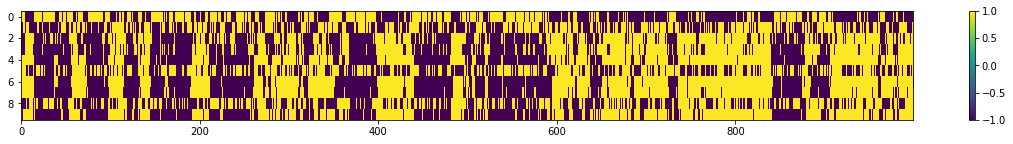

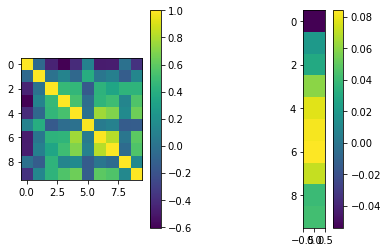

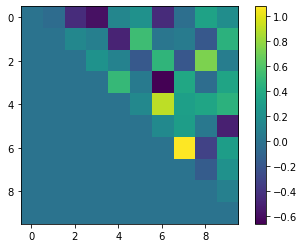

In [81]:
N=10
T=1000

iu1=np.triu_indices(N,1)

I_data = Ising(10)
I_data.H = -1+ 0.05*np.random.randn(N)
I_data.J[iu1] = 1/N + np.random.randn(N*(N-1)//2)/np.sqrt(N)

Data_sample = np.zeros((N,T))

I_data.randomize_state()
for t in range(T):
  I_data.SequentialGlauberStep()
  Data_sample[:,t] = I_data.s

plt.figure(figsize=(20,2))
plt.imshow(Data_sample, aspect='auto', interpolation='none')
plt.colorbar()

m_data = np.mean(Data_sample,axis=1)
Cov_data = np.cov(Data_sample)
print(m_data)
plt.figure()
plt.subplot(122)
plt.imshow(m_data[:,np.newaxis])
plt.colorbar()

plt.subplot(121)
plt.imshow(Cov_data)
plt.colorbar()


plt.figure()
plt.imshow(I_data.J)
plt.colorbar()

## Learning our model

[-0.054  0.02   0.03   0.06   0.078  0.082  0.084  0.072  0.04   0.042]


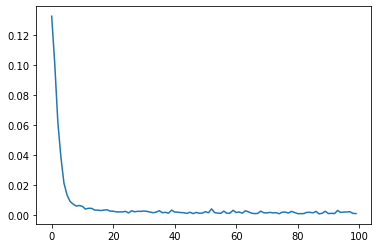

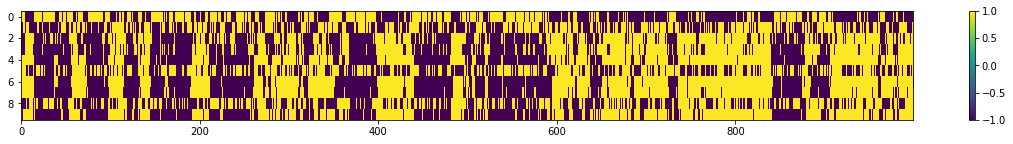

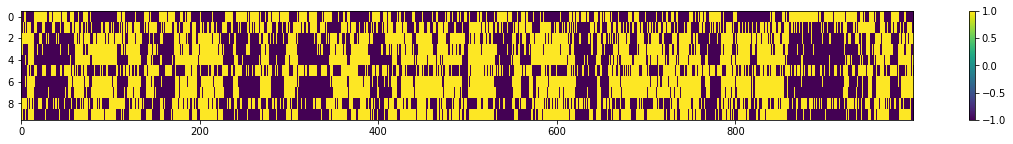

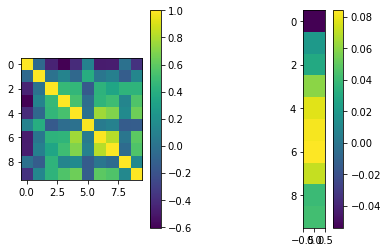

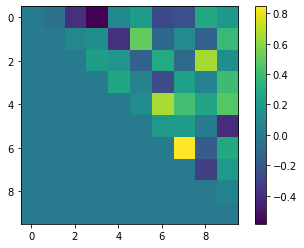

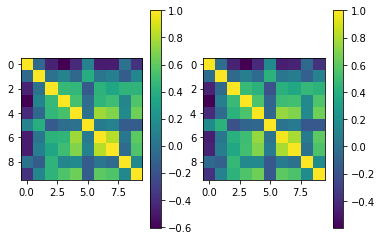

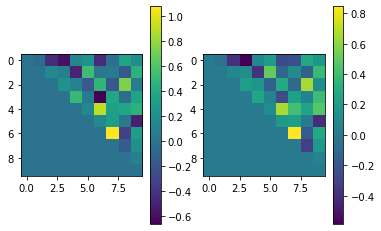

In [85]:
N=10
T=1000

I = Ising(10)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=100
eta=0.1

error = np.zeros(R)

for rep in range(R):
  Model_sample = np.zeros((N,T))
  I.randomize_state()
  for t in range(T):
    I.SequentialGlauberStep()
    Model_sample[:,t] = I.s
  m = np.mean(Model_sample,axis=1)
  Cov  = np.cov(Model_sample)

  I.H += eta*(m_data-m)
  I.J[iu1] += eta*(Cov_data-Cov)[iu1]

  error[rep] = np.mean((Cov_data-Cov)**2)

plt.figure()
plt.plot(error)

plt.figure(figsize=(20,2))
plt.imshow(Data_sample, aspect='auto', interpolation='none')
plt.colorbar()

plt.figure(figsize=(20,2))
plt.imshow(Model_sample, aspect='auto', interpolation='none')
plt.colorbar()

print(m_data)
plt.figure()
plt.subplot(122)
plt.imshow(m_data[:,np.newaxis])
plt.colorbar()

plt.subplot(121)
plt.imshow(Cov_data)
plt.colorbar()


plt.figure()
plt.imshow(I.J)
plt.colorbar()

plt.figure()
plt.subplot(121)
plt.imshow(Cov_data)
plt.colorbar()

plt.subplot(122)
plt.imshow(Cov)
plt.colorbar()

plt.figure()
plt.subplot(121)
plt.imshow(I_data.J)
plt.colorbar()

plt.subplot(122)
plt.imshow(I.J)
plt.colorbar()
